In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import prolif as plf

import safe as sf
import datamol as dm

import mols2grid

from moleval.metrics.metrics import GetMetrics

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
pdb = '2zdt'

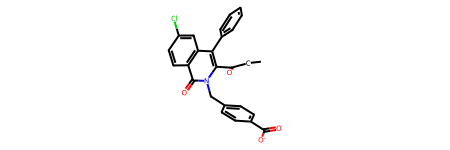

In [4]:
initial_mol = Chem.MolFromMolFile(f"data/docking/{pdb}_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

initial_mol

In [5]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

### Interaction fingerprint for reference molecule

In [6]:
REF_MOL_FILEPATH = f"data/docking/{pdb}_ligand.sdf"
PDB_FILEPATH = f"data/docking/{pdb}.pdb"

fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(REF_MOL_FILEPATH)
fp.run_from_iterable(suppl, prot, progress=True)
df_ifp = fp.to_dataframe()
df_ifp.columns = df_ifp.columns.droplevel(0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_ifp

protein        LYS68.A                        ILE70.A    GLY71.A     VAL78.A  \
interaction HBAcceptor Anionic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                          
0                 True    True       True        True       True        True   

protein                    ALA91.A               ILE124.A  ...   ASN152.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic  ... VdWContact   
Frame                                                      ...              
0                 True        True       True        True  ...       True   

protein       SER193.A    VAL196.A               LEU206.A    46C901.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic Hydrophobic   
Frame                                                                   
0                 True        True       True        True        True   

protein                             HOH986.A             
interaction PiStacking VdWContact HBAcceptor VdWContact  
Frame                                                    
0                 True       True       True       True  

[1 rows x 28 columns]

In [8]:
def ifp_similarity(ref_mol_ifp, df_ifp, df):
    ## Rename columns
    df_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in df_ifp.columns]
    ref_mol_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in ref_mol_ifp.columns]
    

    intersections = []
    weighted_intersections = []

    #iterate over the rows
    for index, row in df_ifp.iterrows():
        count=0
        weighted_count = 0
        #iterate over all columns
        for col_name in df_ifp.columns:
            if col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'VdWContact' in col_name:
                count += 1
                weighted_count += 1
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Hydrophobic' in col_name:
                count += 1
                weighted_count += 2
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'HBAcceptor' in col_name:
                count += 1
                weighted_count += 3
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Anionic' in col_name or 'Cationic' in col_name:
                count += 1
                weighted_count += 4
        
        intersections.append(count)
        weighted_intersections.append(weighted_count)
                
    df['IFP Intersection'] = intersections
    df['Weighted IFP Intersection'] = weighted_intersections

    return df


In [9]:
def compute_features(df, ifp):

    cols = ifp.columns

    num_cols = len(ifp.columns)

    data = {'mol_id' : [],
            'num_interactions' : [],
            'weighted_interactions' : [],
            'num_VdW' : [],
            'num_hydrophobic' : [],
            'num_HBAcceptor' : [],
            'num_ionic' : []}

    for index, row in ifp.iterrows():

        weighted_interactions = 0
        num_VdW = 0
        num_hydrophobic = 0
        num_HBAcceptor = 0
        num_ionic = 0
        
        data['mol_id'].append(row['ID'][0])
        data['num_interactions'].append(row[:-1].sum())

        for value in cols:
            
            if value[1] == 'VdWContact':
                weighted_interactions += 1 * row[value]
                num_VdW += 1 * row[value]
            elif value[1] == 'Hydrophobic':
                weighted_interactions += 2 * row[value]
                num_hydrophobic += 1 * row[value]
            elif value[1] == 'HBAcceptor':
                weighted_interactions += 3 * row[value]
                num_HBAcceptor += 1 * row[value]
            elif value[1] == 'Anionic' or value[1] == 'Cationic':
                weighted_interactions += 4 * row[value]
                num_ionic += 1 * row[value]

        data['weighted_interactions'].append(weighted_interactions)
        data['num_VdW'].append(num_VdW)
        data['num_hydrophobic'].append(num_hydrophobic)
        data['num_HBAcceptor'].append(num_HBAcceptor)
        data['num_ionic'].append(num_ionic)

            

    features = pd.DataFrame(data)

    df = df.merge(features[['mol_id', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic']], left_on='ID', right_on='mol_id', how='left')

    df = df.drop(['mol_id'], axis=1).sort_values(['Docking score'], ascending=True)

    df.dropna(axis=0, subset=['Docking score'], inplace=True)
    df['num_interactions'].fillna(0, inplace=True)
    df['weighted_interactions'].fillna(0, inplace=True)

    return df

In [10]:
def visualize_fingerprint(ifp):

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.heatmap(ifp,cmap=sns.cm.rocket_r)
    ax.set_ylabel("Molecule")
    ax.set_xlabel("Protein Interaction")

    return ax

In [11]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    bad_rings = df.query('min_freq <= 100').copy()
    df = df.query('min_freq > 100').copy()
    return df, bad_rings

In [12]:
models = ['reinvent', 'crem', 'coati', 'safe']
ifps = []
model_df = pd.DataFrame()

In [13]:
for model in models:

    DF_FILEPATH = f'data/{model}_dataframe.csv'
    IFP_FILEPATH = f'data/{model}_ifp.csv'

    temp_df = pd.read_csv(DF_FILEPATH, index_col=0)
    ifp = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

    if model == 'reinvent':
        temp_df['Model'] = model

    temp_df = compute_features(temp_df, ifp)
    temp_df = ifp_similarity(df_ifp, ifp, temp_df)

    model_df = pd.concat((model_df, temp_df))
    

In [14]:
model_df.drop(['Input_SMILES', 'Tanimoto', 'Prior'], axis=1, inplace=True)

In [15]:
model_df, bad_rings = remove_odd_rings(model_df)

In [16]:
model_df

,SMILES,ID,Docking score,rmsd,Model,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,ring_systems,min_ring,min_freq
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,reinvent,27.0,45.0,13.0,10.0,4.0,0.0,21,39,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,reinvent,32.0,48.0,17.0,11.0,3.0,0.0,24,41,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,reinvent,25.0,40.0,11.0,10.0,3.0,0.0,20,36,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,reinvent,29.0,45.0,16.0,10.0,3.0,0.0,22,38,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,reinvent,27.0,42.0,14.0,11.0,2.0,0.0,20,35,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,MOL0116,-6.331114,27.607474,safe,32.0,48.0,17.0,12.0,1.0,1.0,21,39,"[(O=c1[nH]ccc2ccccc12, 2230), (c1cscn1, 61036)...",O=c1[nH]ccc2ccccc12,2230
52,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,MOL0052,-4.646422,10.012813,safe,33.0,52.0,18.0,12.0,2.0,1.0,23,42,"[(O=c1[nH]ccc2ccccc12, 2230), (C1CCCNCC1, 6337...",O=c1[nH]ccc2ccccc12,2230
127,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,MOL0127,-4.419723,27.196813,safe,29.0,43.0,16.0,10.0,1.0,1.0,20,37,"[(O=c1[nH]ccc2ccccc12, 2230), (c1nn[nH]n1, 206...",O=c1[nH]ccc2ccccc12,2230
160,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,MOL0160,-3.819107,28.181917,safe,33.0,46.0,22.0,10.0,0.0,1.0,22,38,"[(O=c1[nH]ccc2ccccc12, 2230), (c1cocn1, 15605)...",O=c1[nH]ccc2ccccc12,2230


In [17]:
bad_rings

,SMILES,ID,Docking score,rmsd,Model,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,ring_systems,min_ring,min_freq
46,CCOc1ccc2c(C(=O)CC)n(Cc3ccc(C(=O)O)cc3)c(=O)c(...,MOL0046,-10.755634,9.745061,reinvent,31.0,47.0,17.0,12.0,2.0,0.0,19,33,"[(O=c1cc2ccccc2c[nH]1, 86), (c1ccccc1, 2260082...",O=c1cc2ccccc2c[nH]1,86
90,COc1ccc2c(C(=O)OC(C)C)n(Cc3ccc(C(=O)O)cc3)c(=O...,MOL0090,-9.814790,8.372586,reinvent,30.0,40.0,19.0,9.0,1.0,0.0,17,27,"[(O=c1cc2ccccc2c[nH]1, 86), (c1ccccc1, 2260082...",O=c1cc2ccccc2c[nH]1,86
2,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,MOL0002,-14.263374,6.541037,crem,26.0,41.0,13.0,11.0,2.0,0.0,21,39,"[(C1N=NN=N1, 59), (O=c1[nH]ccc2ccccc12, 2230),...",C1N=NN=N1,59
125,CCC(=O)C1=C(c2ccccc2)c2cc(Cl)ccc2[NH+]=CN1Cc1c...,MOL0125,-14.674456,7.355187,coati,28.0,45.0,15.0,10.0,2.0,1.0,23,43,"[(C1=Cc2ccccc2[NH+]=CN1, 0), (c1ccccc1, 226008...",C1=Cc2ccccc2[NH+]=CN1,0
126,CCC(=O)C1=C(c2ccc(Cl)cc2)C(=O)N1Cc1ccc(C(=O)[O...,MOL0126,-13.071126,7.871390,coati,26.0,45.0,12.0,10.0,3.0,1.0,23,45,"[(O=C1C=CN1, 0), (c1ccccc1, 2260082), (c1ccccc...",O=C1C=CN1,0
168,CCC(=O)c1cc2c(Cl)c(-c3ccccc3)sc2c(=O)n1Cc1ccc(...,MOL0168,-12.642220,15.916714,coati,31.0,54.0,14.0,12.0,4.0,1.0,25,49,"[(O=c1[nH]ccc2ccsc12, 7), (c1ccccc1, 2260082),...",O=c1[nH]ccc2ccsc12,7
175,CCC(=O)C1=CN(c2ccccc2)c2cc(C(C)(C)C)ccc2N1C(=O...,MOL0175,-12.339231,13.419985,coati,34.0,53.0,19.0,12.0,2.0,1.0,21,41,"[(C1=CNc2ccccc2N1, 2), (c1ccccc1, 2260082), (c...",C1=CNc2ccccc2N1,2
111,CCC(=O)c1c(-c2ccccc2)oc2c(Cl)cc-2n1Cc1ccc(C(=O...,MOL0111,-12.305086,8.101304,coati,25.0,39.0,13.0,8.0,2.0,1.0,21,39,"[(c1coc2ccc-2[nH]1, 0), (c1ccccc1, 2260082), (...",c1coc2ccc-2[nH]1,0
51,CC[n+]1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n(Cc2ccc(C...,MOL0051,-11.997536,20.762123,coati,29.0,49.0,14.0,11.0,3.0,1.0,24,46,"[(O=c1[nH]c(=O)c2ccccc2c[nH+]1, 0), (c1ccccc1,...",O=c1[nH]c(=O)c2ccccc2c[nH+]1,0
176,CCc1[nH+]c2c(c(-c3ccccc3[O-])nn2Cc2ccc(C(=O)[O...,MOL0176,-11.835547,12.727678,coati,36.0,55.0,21.0,12.0,2.0,1.0,26,47,"[(O=c1[nH]c[nH+]c2[nH]ncc12, 0), (c1ccccc1, 22...",O=c1[nH]c[nH+]c2[nH]ncc12,0


In [18]:
bad_smiles = bad_rings['SMILES']

bad_mols = [Chem.MolFromSmiles(smile) for smile in bad_smiles]

In [19]:
mols2grid.display(bad_mols, size=(250, 125))

MolGridWidget()

<Axes: xlabel='Model'>

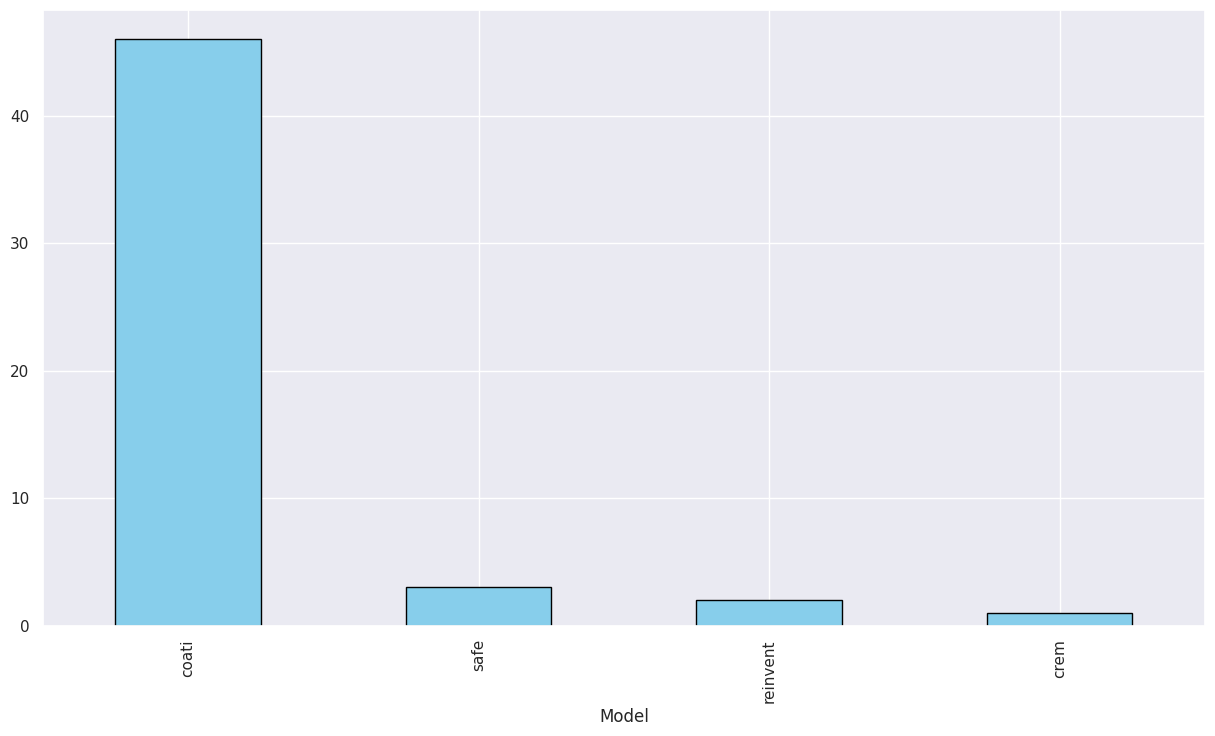

In [20]:
category_counts = bad_rings['Model'].value_counts()

# Step 4: Plot the bar chart
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

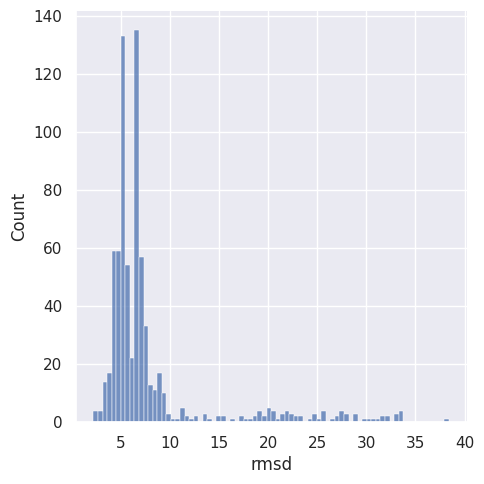

In [34]:
sns.displot(model_df.rmsd);

In [21]:
df_rmsd_ok = model_df.query("rmsd <= 10").copy()

In [22]:
df_rmsd_ok

,SMILES,ID,Docking score,rmsd,Model,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,ring_systems,min_ring,min_freq
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,reinvent,27.0,45.0,13.0,10.0,4.0,0.0,21,39,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,reinvent,32.0,48.0,17.0,11.0,3.0,0.0,24,41,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,reinvent,25.0,40.0,11.0,10.0,3.0,0.0,20,36,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,reinvent,29.0,45.0,16.0,10.0,3.0,0.0,22,38,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,reinvent,27.0,42.0,14.0,11.0,2.0,0.0,20,35,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,O=C([O-])c1ccc(Cn2c(C(=O)CCC3CCNCC3)c(-c3ccccc...,MOL0012,-9.905931,6.989526,safe,28.0,49.0,13.0,11.0,2.0,2.0,23,44,"[(O=c1[nH]ccc2ccccc12, 2230), (c1cc[nH+]cc1, 1...",O=c1[nH]ccc2ccccc12,2230
191,O=C([O-])c1ccc(C(N2CCOCC2)n2c(C(=O)CCN3CCOCC3)...,MOL0191,-8.210854,6.725291,safe,33.0,51.0,18.0,10.0,3.0,1.0,24,44,"[(O=c1[nH]ccc2ccccc12, 2230), (C1COCCN1, 70960...",O=c1[nH]ccc2ccccc12,2230
115,O=C([O-])c1ccc(C(SC(F)(F)F)n2c(C(=O)CCNC(O)=NC...,MOL0115,-8.133378,6.221507,safe,33.0,52.0,18.0,9.0,4.0,1.0,22,40,"[(O=c1[nH]ccc2ccccc12, 2230), (c1ccccc1, 22600...",O=c1[nH]ccc2ccccc12,2230
24,O=C([O-])c1ccc(C(N2CCOCC2)n2c(C(=O)CCn3cc[n+](...,MOL0024,-7.557238,3.956228,safe,33.0,55.0,17.0,11.0,4.0,1.0,25,48,"[(c1c[nH+]c[nH]1, 2209), (O=c1[nH]ccc2ccccc12,...",c1c[nH+]c[nH]1,2209


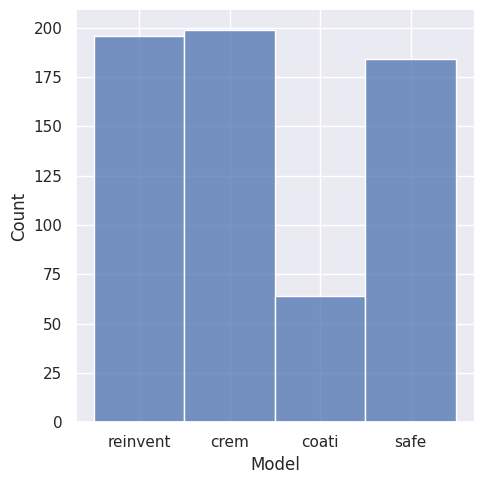

In [23]:
sns.displot(df_rmsd_ok.Model);

In [24]:
smiles = df_rmsd_ok['SMILES'].to_list()

In [25]:
y = df_rmsd_ok['Model'].to_numpy().reshape(-1, 1)

### Evaluating Metrics w/ MolScore

In [32]:
from molscore import MolScore

In [33]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')
scores = ms.score(smiles)

Found existing directory, appending current time to distinguish


Found existing rascore-env
Launching server: conda run -n rascore-env python /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/scoring_functions/servers/rascore_server.py --port 8029 --model_path /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/data/models/RAScore/XGB_chembl_ecfp_counts/model.pkl


In [34]:
# Once finished
metrics = ms.compute_metrics(
    endpoints=None, # Optional list: by default will use the running final score/reward value
    thresholds=None,  # Optional list: if specified will calculate the yield of molecules above that threshold 
    # chemistry_filters_basic=False,  # Optional, bool: Additionally re-calculate metrics after filtering out unreasonable chemistry
    budget=10000,  # Optional, int: Calculate metrics only with molecules within this budget
    n_jobs=1,  # Optional, int: Multiprocessing
    benchmark=None,  # Optional, str: Name of benchmark, this may specify additional metrics to compute
)

In [36]:
df = pd.read_csv('molscore/2024_07_30_mol2mol_feature_selection_16_14_19/iterations/000001_scores.csv', index_col=0)

In [37]:
df.head()

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,2.946556,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,3,0.514286,0.514286,0.679245,0.679245,0.982867,1,1.0,1.0,6.142683
1,mol2mol,feature_selection,1,1,2.946556,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,0,0.521127,0.521127,0.685185,0.685185,0.948534,1,1.0,1.0,6.142683
2,mol2mol,feature_selection,1,2,2.946556,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.910709,1,1.0,1.0,6.142683
3,mol2mol,feature_selection,1,3,2.946556,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,0,0.438356,0.438356,0.609524,0.609524,0.945486,1,1.0,1.0,6.142683
4,mol2mol,feature_selection,1,4,2.946556,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,3,0.522388,0.522388,0.686275,0.686275,0.957991,1,1.0,1.0,6.142683


In [38]:
df.drop(['desc_MolecularFormula',
         'dice_Sim', 'dice_Cmpd1_Sim',
         'tanimoto_Sim', 'tanimoto_Cmpd1_Sim',
         'desc_SAscore', 'desc_PenLogP',
         'desc_MolWt', 'desc_NumHAcceptors',
         'desc_NumHDonors', 'desc_CLogP',
         'desc_TPSA', 'desc_NumRotatableBonds',
         'desc_MaxConsecutiveRotatableBonds',
         'desc_NumAromaticRings', 'desc_FlourineCount',
         'desc_FormalCharge', 'desc_RingCount',
         'desc_NumAliphaticRings', 'desc_HeavyAtomCount',
         'desc_HeavyAtomMolWt'], axis=1, inplace=True)

In [39]:
X = df.iloc[:, 10:-4]

Adding new features

In [40]:
weighted_ifp_intersection = df_rmsd_ok['Weighted IFP Intersection'].values

X['Docking score'] = df_rmsd_ok['Docking score'].values
X['interaction weight ratio'] = df_rmsd_ok['weighted_interactions'].values / df_rmsd_ok['num_interactions'].values
X['rmsd'] = df_rmsd_ok['rmsd'].values
X['Weighted IFP Similarity'] = weighted_ifp_intersection / df_rmsd_ok['weighted_interactions'].values

In [41]:
X.head()

,desc_QED,desc_NumHeteroatoms,desc_Bertz,RAScore_pred_proba,Docking score,interaction weight ratio,rmsd,Weighted IFP Similarity
0,0.351621,9,1507.458087,0.982867,-16.624857,1.666667,3.737471,0.866667
1,0.340885,7,1488.314380,0.948534,-16.540930,1.500000,3.676144,0.854167
2,0.271819,6,1406.508497,0.910709,-16.529593,1.600000,5.569642,0.900000
3,0.397044,7,1467.520115,0.945486,-16.301600,1.551724,3.785833,0.844444
4,0.387424,8,1470.935757,0.957991,-16.295380,1.555556,5.360354,0.833333


#### Exploratory Data Analysis:

* Normalizing columns
* Evaluating correlations between features

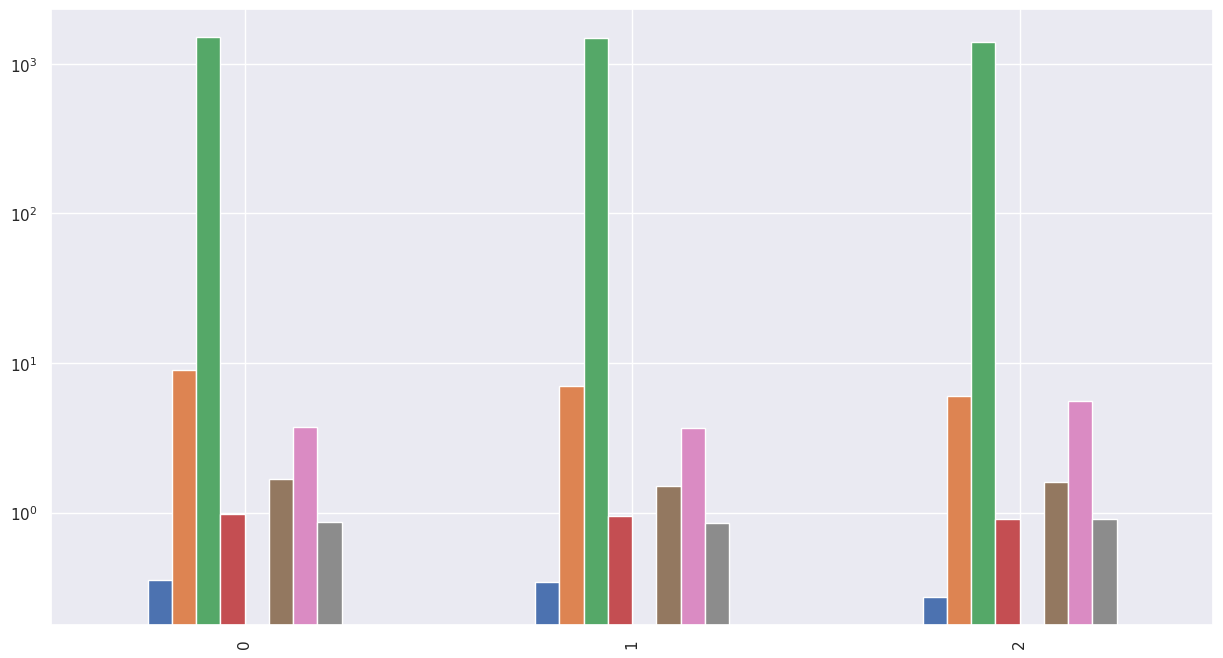

In [42]:
X[:3].plot(kind='bar', legend=False, logy=True);

In [43]:
X_normalized = X.drop(['Docking score'], axis=1)

X_normalized['Docking score'] = np.abs(X['Docking score'])

# Normalizing each column using min-max scaler
for column in X_normalized.columns:
   
   X_normalized[column] = (X_normalized[column] - X_normalized[column].min()) / (X_normalized[column].max() - X_normalized[column].min())

# X_normalized['desc_CLogP'] = X['desc_CLogP'] / X['desc_CLogP'].max()

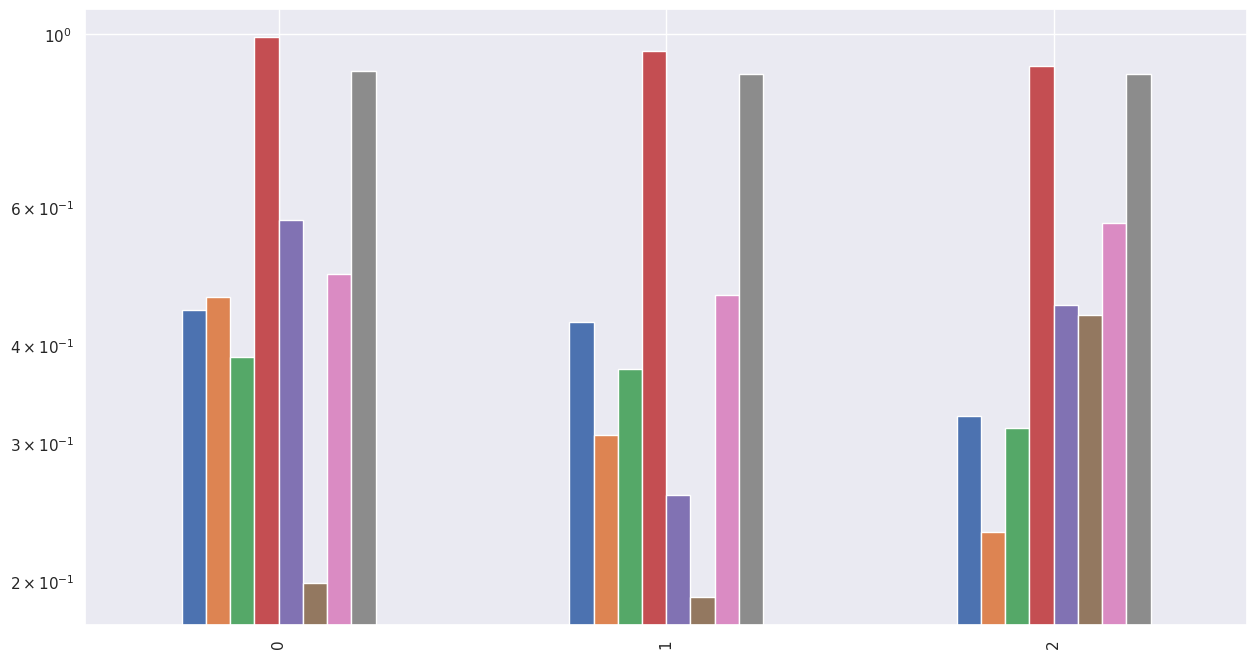

In [44]:
X_normalized[:3].plot(kind='bar', legend=False, logy=True);

In [45]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [46]:
X['Model'] = ord.squeeze()

In [47]:
X.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,desc_QED,desc_NumHeteroatoms,desc_Bertz,RAScore_pred_proba,Docking score,interaction weight ratio,rmsd,Weighted IFP Similarity,Model
desc_QED,1.000000,-0.275191,-0.552671,0.085952,-0.200337,-0.006372,-0.031462,-0.199562,-0.270550
desc_NumHeteroatoms,-0.275191,1.000000,0.742906,-0.178248,0.184621,0.264955,-0.348065,-0.053745,0.612684
desc_Bertz,-0.552671,0.742906,1.000000,-0.043068,0.286762,0.296674,-0.268003,0.036194,0.730940
RAScore_pred_proba,0.085952,-0.178248,-0.043068,1.000000,-0.129451,0.228976,0.063765,0.267895,-0.020492
Docking score,-0.200337,0.184621,0.286762,-0.129451,1.000000,-0.289770,0.126697,-0.365013,0.121079
interaction weight ratio,-0.006372,0.264955,0.296674,0.228976,-0.289770,1.000000,-0.205203,0.465717,0.261043
rmsd,-0.031462,-0.348065,-0.268003,0.063765,0.126697,-0.205203,1.000000,0.011291,-0.499156
Weighted IFP Similarity,-0.199562,-0.053745,0.036194,0.267895,-0.365013,0.465717,0.011291,1.000000,-0.165098
Model,-0.270550,0.612684,0.730940,-0.020492,0.121079,0.261043,-0.499156,-0.165098,1.000000


## Random Forest Classification

In [48]:
enc = OneHotEncoder(handle_unknown='ignore')

In [49]:
enc.fit_transform(y)

<643x4 sparse matrix of type '<class 'numpy.float64'>'
	with 643 stored elements in Compressed Sparse Row format>

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.2, random_state=1)

In [51]:
len(X_train)

514

In [52]:
len(X_test)

129

In [53]:
rf = RandomForestClassifier(n_estimators=500,
                            class_weight='balanced',
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=1)

In [54]:
y_pred = rf.predict(X_test)

In [55]:
precision = precision_score(y_pred, y_test, average='micro')

print(f'Precision score: {precision}')

print(classification_report(y_test, y_pred))

Precision score: 0.937984496124031
              precision    recall  f1-score   support

       coati       1.00      0.62      0.76        13
        crem       0.91      0.98      0.94        41
    reinvent       0.91      0.94      0.93        34
        safe       0.98      1.00      0.99        41

    accuracy                           0.94       129
   macro avg       0.95      0.88      0.90       129
weighted avg       0.94      0.94      0.93       129



In [56]:
weights = rf.feature_importances_
vars = X_normalized.columns

d = {'vars': vars, 'weights': weights}

rf_features = pd.DataFrame(data=d).sort_values(['weights'], ascending=False, ignore_index=True)

rf_features[:25]

,vars,weights
0,desc_Bertz,0.227972
1,Weighted IFP Similarity,0.176361
2,desc_QED,0.157649
3,Docking score,0.102627
4,rmsd,0.097127
5,desc_NumHeteroatoms,0.091666
6,interaction weight ratio,0.085005
7,RAScore_pred_proba,0.061592
